In [1]:
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
def split_data(source_folder, train_folder, val_folder, test_folder, train_size=0.7, val_size=0.15):
    _, dirs, _ = next(os.walk(source_folder))

    for d in dirs:
        os.makedirs(os.path.join(train_folder, d), exist_ok=True)
        os.makedirs(os.path.join(val_folder, d), exist_ok=True)
        os.makedirs(os.path.join(test_folder, d), exist_ok=True)

        files = os.listdir(os.path.join(source_folder, d))
        np.random.shuffle(files)
        train_count = int(len(files) * train_size)
        val_count = int(len(files) * val_size)

        for i, file in enumerate(files):
            if i < train_count:
                dest_folder = os.path.join(train_folder, d)
            elif i < train_count + val_count:
                dest_folder = os.path.join(val_folder, d)
            else:
                dest_folder = os.path.join(test_folder, d)

            shutil.copy(os.path.join(source_folder, d, file), os.path.join(dest_folder, file))

# 路径设置
source_folder = 'D:/tester01'
train_folder = 'D:/tester01_split/train'
val_folder = 'D:/tester01_split/val'
test_folder = 'D:/tester01_split/test'

# 数据划分
split_data(source_folder, train_folder, val_folder, test_folder)

In [3]:
# 数据增强和预处理
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 训练集生成器
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 验证集生成器
validation_generator = datagen.flow_from_directory(
    val_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 测试集生成器
test_generator = datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2143 images belonging to 3 classes.
Found 458 images belonging to 3 classes.
Found 463 images belonging to 3 classes.


In [8]:
# 加载预训练的 VGG16 模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 冻结基模型层
for layer in base_model.layers:
    layer.trainable = False

# 添加自定义层
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3个类别

model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# 训练模型
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  
)

Epoch 1/10
66/66 [==============================] - 257s 4s/step - loss: 2.7368 - accuracy: 0.8721 - val_loss: 0.6696 - val_accuracy: 0.9531
Epoch 2/10
66/66 [==============================] - 249s 4s/step - loss: 0.0915 - accuracy: 0.9891 - val_loss: 0.4373 - val_accuracy: 0.9643
Epoch 3/10
66/66 [==============================] - 246s 4s/step - loss: 0.1049 - accuracy: 0.9853 - val_loss: 0.5886 - val_accuracy: 0.9598
Epoch 4/10
66/66 [==============================] - 243s 4s/step - loss: 0.0485 - accuracy: 0.9934 - val_loss: 0.4824 - val_accuracy: 0.9643
Epoch 5/10
66/66 [==============================] - 242s 4s/step - loss: 0.0628 - accuracy: 0.9905 - val_loss: 0.9539 - val_accuracy: 0.9531
Epoch 6/10
66/66 [==============================] - 242s 4s/step - loss: 0.0991 - accuracy: 0.9910 - val_loss: 0.5678 - val_accuracy: 0.9598
Epoch 7/10
66/66 [==============================] - 256s 4s/step - loss: 0.0446 - accuracy: 0.9962 - val_loss: 0.4315 - val_accuracy: 0.9665
Epoch 8/10
66

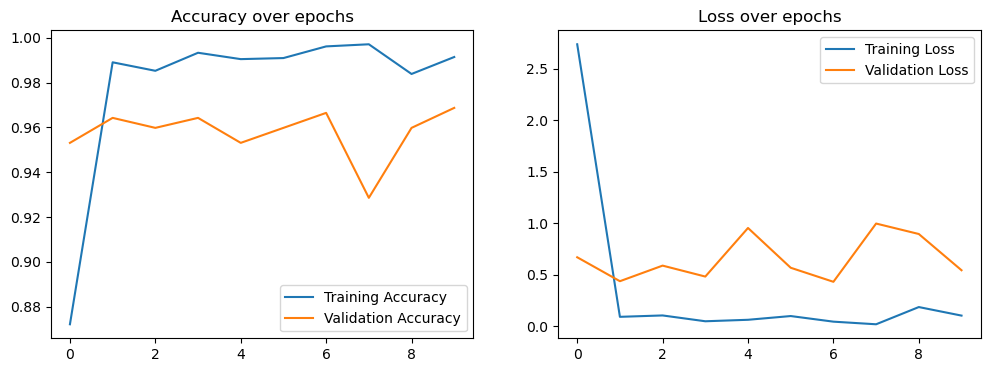

15/15 [==============================] - 44s 3s/step - loss: 0.5808 - accuracy: 0.9654
Test Accuracy: 96.54%


In [10]:
# 绘制训练和验证准确率和损失
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# 评估模型在测试集上的性能
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [11]:
# 保存模型
model.save('ly.h5') 